In [1]:
from env import user, password, host
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import explained_variance_score
from sklearn.linear_model import TweedieRegressor

import warnings
warnings.filterwarnings("ignore")

import os
import wrangle_zillow

In [2]:
train, validate, test = wrangle_zillow.wrangle_zillow()

In [3]:
target = 'tax_value'
X_train, X_validate, X_test, y_train, y_validate, y_test = wrangle_zillow.x_y(train, validate, test, target)

In [4]:
X_train_scaled, X_validate_scaled, X_test_scaled = wrangle_zillow.scaler(X_train, X_validate, X_test)

In [5]:
k = 3
f_feature = wrangle_zillow.select_kbest(X_train_scaled, y_train, k)
f_feature

['bathrooms', 'area', 'tax_amount']

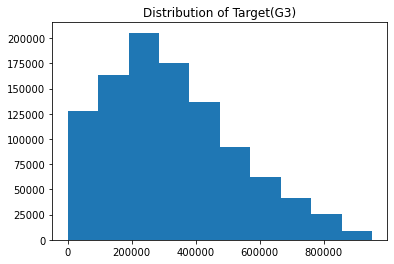

In [6]:
# how do we determine distribution?
plt.hist(y_train)
plt.title('Distribution of Target(G3)')
plt.show()

## Baseline & RMSE

In [7]:
# We need y_train and y_validate to be dataframes to append the new columns with predicted values. 
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)
y_train.head()

,tax_value
10057,248240.0
2004969,88390.0
306031,81169.0
1038594,119174.0
270959,432268.0


In [8]:
# 1. Add target mean column as baseline check
y_train['mean_pred'] = y_train.tax_value.mean()
y_validate['mean_pred'] = y_validate.tax_value.mean()

In [9]:
y_train.head()

,tax_value,mean_pred
10057,248240.0,327962.928757
2004969,88390.0,327962.928757
306031,81169.0,327962.928757
1038594,119174.0,327962.928757
270959,432268.0,327962.928757


In [10]:
y_validate.head()

,tax_value,mean_pred
1214918,73516.0,327581.089171
1799487,408323.0,327581.089171
1799139,219939.0,327581.089171
1099915,308588.0,327581.089171
1534222,181994.0,327581.089171


In [11]:
# 2. Add target median column as baseline check

In [12]:
y_train['median_pred'] = y_train.tax_value.median()
y_validate['median_pred'] = y_validate.tax_value.median()

In [13]:
y_train.head()

,tax_value,mean_pred,median_pred
10057,248240.0,327962.928757,296624.0
2004969,88390.0,327962.928757,296624.0
306031,81169.0,327962.928757,296624.0
1038594,119174.0,327962.928757,296624.0
270959,432268.0,327962.928757,296624.0


In [14]:
y_validate.head()

,tax_value,mean_pred,median_pred
1214918,73516.0,327581.089171,296436.0
1799487,408323.0,327581.089171,296436.0
1799139,219939.0,327581.089171,296436.0
1099915,308588.0,327581.089171,296436.0
1534222,181994.0,327581.089171,296436.0


In [15]:
# 3. RMSE of target mean
rmse_train = mean_squared_error(y_train.tax_value, y_train.mean_pred) ** .5
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.mean_pred) ** (0.5)

In [16]:
# show RMSE Score for train and validate
print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

RMSE using Mean
Train/In-Sample:  198987.48 
Validate/Out-of-Sample:  198712.32


In [17]:
# 4. RMSE of target median

In [18]:
# 3. RMSE of target median
rmse_train = mean_squared_error(y_train.tax_value, y_train.median_pred) ** .5
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.median_pred) ** (0.5)

In [19]:
# show RMSE Score for train and validate
print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

RMSE using Mean
Train/In-Sample:  201440.18 
Validate/Out-of-Sample:  201138.27


In [20]:
metric_df = pd.DataFrame(data=[
            {
                'model': 'mean_baseline', 
                'RMSE_train': rmse_train,
                'RMSE_validate': rmse_validate
                }
            ])

In [21]:
metric_df

,model,RMSE_train,RMSE_validate
0,mean_baseline,201440.177615,201138.266112


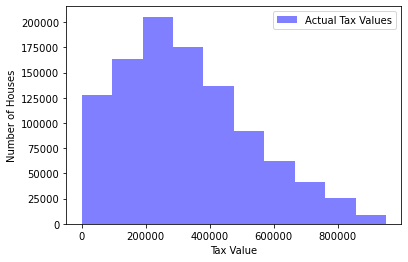

In [22]:
# plot to visualize actual vs predicted. 
plt.hist(y_train.tax_value, color='blue', alpha=.5, label="Actual Tax Values")
# plt.hist(y_train.mean_pred, bins=1, color='red', alpha=.5,  label="Predicted Tax Value - Mean")
# plt.hist(y_train.median_pred, bins=1, color='orange', alpha=.5, label="Predicted Tax Value - Median")
plt.xlabel("Tax Value")
plt.ylabel("Number of Houses")
plt.legend()
plt.show()

## LinearRegression (OLS)

In [23]:
# create, fit, predict ols model
ols = LinearRegression()
ols.fit(X_train, y_train.tax_value)
y_train['ols_pred'] = ols.predict(X_train)

In [24]:
y_train.head()

,tax_value,mean_pred,median_pred,ols_pred
10057,248240.0,327962.928757,296624.0,195126.825165
2004969,88390.0,327962.928757,296624.0,116278.262390
306031,81169.0,327962.928757,296624.0,88283.690213
1038594,119174.0,327962.928757,296624.0,129909.158958
270959,432268.0,327962.928757,296624.0,421940.014799


In [25]:
ols.coef_

array([-3375.15980216,  1244.65719763,     9.46066456,  -265.72436141,
          85.40846008,   752.51988192])

In [26]:
# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train.ols_pred) ** (1/2)

# predict validate
y_validate['ols_pred'] = ols.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.ols_pred) ** (1/2)

print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for OLS using LinearRegression
Training/In-Sample:  46002.9401089558 
Validation/Out-of-Sample:  46523.64027200634


In [27]:
metric_df = metric_df.append({
    'model': 'OLS Regressor', 
    'RMSE_train': rmse_train,
    'RMSE_validate': rmse_validate,
    }, ignore_index=True)

In [28]:
metric_df

,model,RMSE_train,RMSE_validate
0,mean_baseline,201440.177615,201138.266112
1,OLS Regressor,46002.940109,46523.640272


## LassoLars

In [29]:
# create the model object
lars = LassoLars(alpha=0.01)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series!
lars.fit(X_train, y_train.tax_value)

# predict train
y_train['lars_pred'] = lars.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train.lars_pred) ** (1/2)

# predict validate
y_validate['lars_pred'] = lars.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.lars_pred) ** (1/2)

print("RMSE for Lasso + Lars\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate,
     "\nDifference: ", rmse_validate - rmse_train)


RMSE for Lasso + Lars
Training/In-Sample:  46002.95304465937 
Validation/Out-of-Sample:  46523.63206505731 
Difference:  520.6790203979399


In [30]:
lars.coef_

array([-3340.01468539,  1210.82429651,     9.43352051,  -264.42100794,
          85.4054865 ,   751.71146899])

In [31]:
metric_df = metric_df.append({
    'model': 'lasso_alpha0.01', 
    'RMSE_train': rmse_train,
    'RMSE_validate': rmse_validate,
    }, ignore_index=True)

In [32]:
metric_df

,model,RMSE_train,RMSE_validate
0,mean_baseline,201440.177615,201138.266112
1,OLS Regressor,46002.940109,46523.640272
2,lasso_alpha0.01,46002.953045,46523.632065


## TweedieRegressor (GLM)

In [33]:
# create the model object
glm = TweedieRegressor(power=1, alpha=.1)


# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
glm.fit(X_train, y_train.tax_value)

# predict train
y_train['glm_pred'] = glm.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train.glm_pred) ** (1/2)

# predict validate
y_validate['glm_pred'] = glm.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.glm_pred) ** (1/2)

print("RMSE for GLM using Tweedie, power=0 & alpha=0\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for GLM using Tweedie, power=0 & alpha=0
Training/In-Sample:  198987.47875695032 
Validation/Out-of-Sample:  198712.68534357747


In [34]:
metric_df = metric_df.append({
    'model': 'glm_poisson', 
    'RMSE_train': rmse_train,
    'RMSE_validate': rmse_validate,
    }, ignore_index=True)

In [35]:
metric_df

,model,RMSE_train,RMSE_validate
0,mean_baseline,201440.177615,201138.266112
1,OLS Regressor,46002.940109,46523.640272
2,lasso_alpha0.01,46002.953045,46523.632065
3,glm_poisson,198987.478757,198712.685344


## Polynomial Regression
### Tranform using Polynomial Features set to degrees

In [36]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=2)

# fit and transform X_train_scaled
X_train_degree2 = pf.fit_transform(X_train)

# transform X_validate_scaled & X_test_scaled
X_validate_degree2 = pf.transform(X_validate)
X_test_degree2 =  pf.transform(X_test)

### Apply Linear Regression to transformed data

In [37]:
# create the model object
lm2 = LinearRegression()

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm2.fit(X_train_degree2, y_train.tax_value)

# predict train
y_train['lm2_pred'] = lm2.predict(X_train_degree2)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train.lm2_pred) ** (1/2)

# predict validate
y_validate['lm2_pred'] = lm2.predict(X_validate_degree2)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.lm2_pred) ** 0.5

print("RMSE for Polynomial Model, degrees=2\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Polynomial Model, degrees=2
Training/In-Sample:  43791.20382472724 
Validation/Out-of-Sample:  44342.00886008758


In [38]:
metric_df = metric_df.append({
    'model': 'quadratic', 
    'RMSE_train': rmse_train,
    'RMSE_validate': rmse_validate,
    }, ignore_index=True)

In [39]:
metric_df

,model,RMSE_train,RMSE_validate
0,mean_baseline,201440.177615,201138.266112
1,OLS Regressor,46002.940109,46523.640272
2,lasso_alpha0.01,46002.953045,46523.632065
3,glm_poisson,198987.478757,198712.685344
4,quadratic,43791.203825,44342.008860


## Evaluate
### Plotting Actual vs. Predicted Values

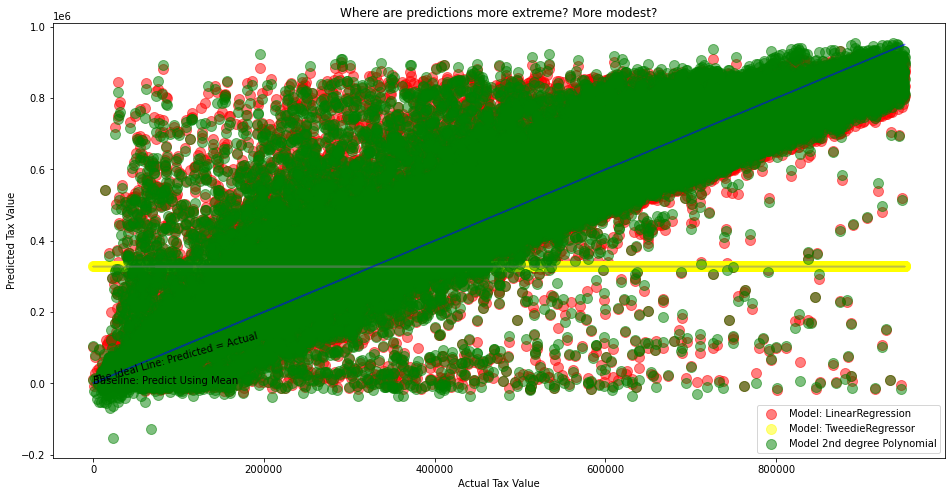

In [40]:
# y_validate.head()
plt.figure(figsize=(16,8))
plt.plot(y_validate.tax_value, y_validate.mean_pred, alpha=.5, color="gray", label='_nolegend_')
plt.annotate("Baseline: Predict Using Mean", (16, 9.5))
plt.plot(y_validate.tax_value, y_validate.tax_value, alpha=.5, color="blue", label='_nolegend_')
plt.annotate("The Ideal Line: Predicted = Actual", (.5, 3.5), rotation=15.5)

plt.scatter(y_validate.tax_value, y_validate.ols_pred, 
            alpha=.5, color="red", s=100, label="Model: LinearRegression")
plt.scatter(y_validate.tax_value, y_validate.glm_pred, 
            alpha=.5, color="yellow", s=100, label="Model: TweedieRegressor")
plt.scatter(y_validate.tax_value, y_validate.lm2_pred, 
            alpha=.5, color="green", s=100, label="Model 2nd degree Polynomial")
plt.legend()
plt.xlabel("Actual Tax Value")
plt.ylabel("Predicted Tax Value")
plt.title("Where are predictions more extreme? More modest?")
# plt.annotate("The polynomial model appears to overreact to noise", (2.0, -10))
# plt.annotate("The OLS model (LinearRegression)\n appears to be most consistent", (15.5, 3))
plt.show()

### Residual Plots: Plotting the Errors in Predictions

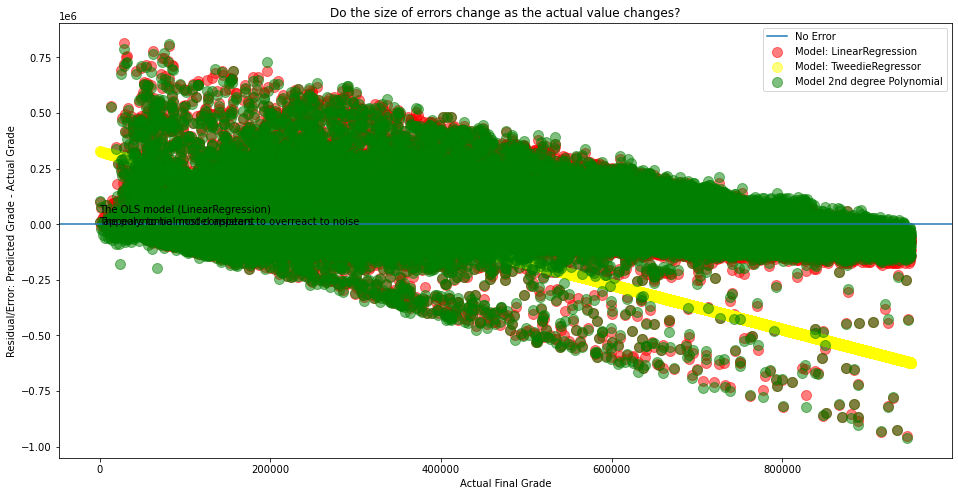

In [41]:
# y_validate.head()
plt.figure(figsize=(16,8))
plt.axhline(label="No Error")
plt.scatter(y_validate.tax_value, y_validate.ols_pred - y_validate.tax_value , 
            alpha=.5, color="red", s=100, label="Model: LinearRegression")
plt.scatter(y_validate.tax_value, y_validate.glm_pred - y_validate.tax_value, 
            alpha=.5, color="yellow", s=100, label="Model: TweedieRegressor")
plt.scatter(y_validate.tax_value, y_validate.lm2_pred - y_validate.tax_value, 
            alpha=.5, color="green", s=100, label="Model 2nd degree Polynomial")
plt.legend()
plt.xlabel("Actual Final Grade")
plt.ylabel("Residual/Error: Predicted Grade - Actual Grade")
plt.title("Do the size of errors change as the actual value changes?")
plt.annotate("The polynomial model appears to overreact to noise", (2.0, -10))
plt.annotate("The OLS model (LinearRegression)\n appears to be most consistent", (15.5, 3))
plt.show()

## Histograms

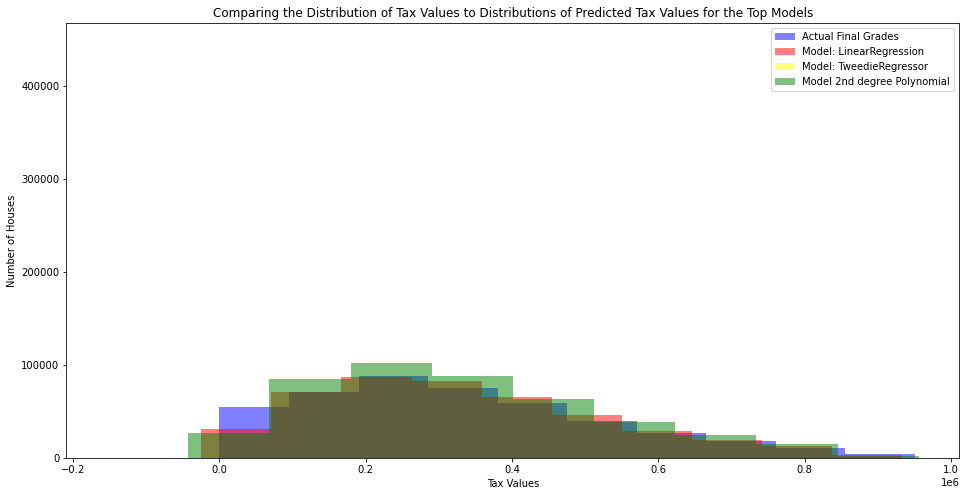

In [42]:
# plot to visualize actual vs predicted. 
plt.figure(figsize=(16,8))
plt.hist(y_validate.tax_value, color='blue', alpha=.5, label="Actual Final Grades")
plt.hist(y_validate.ols_pred, color='red', alpha=.5, label="Model: LinearRegression")
plt.hist(y_validate.glm_pred, color='yellow', alpha=.5, label="Model: TweedieRegressor")
plt.hist(y_validate.lm2_pred, color='green', alpha=.5, label="Model 2nd degree Polynomial")
plt.xlabel("Tax Values")
plt.ylabel("Number of Houses")
plt.title("Comparing the Distribution of Tax Values to Distributions of Predicted Tax Values for the Top Models")
plt.legend()
plt.show()

In [43]:
metric_df

,model,RMSE_train,RMSE_validate
0,mean_baseline,201440.177615,201138.266112
1,OLS Regressor,46002.940109,46523.640272
2,lasso_alpha0.01,46002.953045,46523.632065
3,glm_poisson,198987.478757,198712.685344
4,quadratic,43791.203825,44342.008860


### Model Selection & Out-of-Sample Evaluation
#### Model selected: lars (using Lasso lars with alpha = 0.01)

In [47]:
y_test = pd.DataFrame(y_test)

# predict on test
y_test['lars_pred'] = lars.predict(X_test)

# evaluate: rmse
rmse_test = mean_squared_error(y_test.tax_value, y_test.lars_pred) ** (1/2)

print("RMSE for OLS Model using LinearRegression\nOut-of-Sample Performance: ", rmse_test)

RMSE for OLS Model using LinearRegression
Out-of-Sample Performance:  46040.097404554785
